## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [1]:
import numpy as np

# Load model parameters 
parameters = np.load('sample_data/analytic_params.npy')
responses = np.empty((parameters.shape[0], 4), dtype='float64')

# Construct model responses
responses[:, 0] = parameters[:, 4]
responses[:, 1] = np.abs(parameters[:, 2] * parameters[:, 3]-1)
responses[:, 2] = np.sqrt(np.minimum(parameters[:, 2], parameters[:, 3]))
responses[:, 3] = np.sqrt(parameters[:, 4])

In [2]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [3]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [4]:
from pyDGSA.dgsa import dgsa

parameter_names=['v', 'w', 'x', 'y', 'z']
mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

   sensitivity  confidence
v     0.654048    0.247579
w     0.352028    0.160779
x     1.673571    0.675922
y     1.562287    0.728442
z     3.067931    1.360178


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [5]:
cluster_names = ['Low cluster', 'Medium cluster', 'High cluster']

cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

   Low cluster  Medium cluster  High cluster
v     1.134934        0.326449      1.040575
w     0.403935        0.439593      0.495377
x     1.253258        3.144842      2.019245
y     1.124165        2.957833      1.878481
z     5.708407        2.289685      4.197256


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [6]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/5 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

      sensitivity
w | v    0.787201
x | y    0.757857
v | y    0.697837
z | x    0.665496
y | x    0.630192
y | z    0.624331
z | v    0.622123
y | v    0.594396
v | w    0.584742
x | v    0.572119
x | w    0.542225
w | y     0.51582
z | y    0.507147
v | x    0.497402
x | z    0.477784
z | w    0.471927
v | z    0.465148
y | w    0.442274
w | x    0.415101
w | z    0.370712


Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [7]:
sens = dgsa_interactions(parameters, labels, 
                         cond_parameters=['x', 'y'], 
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

      sensitivity
z | x    0.674234
y | x    0.642389
z | y    0.607186
w | y    0.602743
x | y     0.60038
v | y    0.583312
v | x    0.532255
w | x    0.441905


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [8]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/5 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

      Low cluster Medium cluster High cluster
w | v     0.75241       0.739962     0.858363
x | v    0.699492       0.415537     0.596321
y | v    0.302215       0.929279     0.561909
z | v    0.334687       0.786516     0.748022
v | w    0.393425       0.700639     0.665202
x | w    0.803099       0.516305     0.304179
y | w    0.440259        0.36848     0.520396
z | w     0.45921       0.363127     0.591891
v | x     0.75692       0.379754     0.339398
w | x    0.525015       0.385685     0.342099
y | x    0.372631       0.357211     1.155234
z | x    0.982874       0.631311     0.394399
v | y    0.481576       1.047825     0.538801
w | y     0.46336       0.255371      0.82904
x | y    0.401196       0.356207     1.535685
z | y    0.672427       0.587719     0.246033
v | z    0.198872       0.810759     0.402836
w | z    0.285981       0.228263      0.59762
x | z    0.406072       0.679779     0.340208
y | z    0.888311       0.653116     0.302126


To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [9]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/5 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

      Low cluster                     Medium cluster                      \
            Bin 0     Bin 1     Bin 2          Bin 0     Bin 1     Bin 2   
w | v     0.48371  0.992037  0.763649        0.43772  0.873563  0.900908   
x | v    0.901058  0.726121  0.472812       0.523922  0.449284  0.267327   
y | v    0.323981  0.332444  0.250672       1.351396  0.898135  0.537013   
z | v     0.26501  0.427394   0.33232       1.159732  0.298811  0.899533   
v | w    0.241265  0.319099  0.638153       0.436344  0.684505  0.993041   
x | w    1.002239  0.980285  0.399947       0.462415  0.635341  0.444983   
y | w    0.521734   0.25083  0.525726       0.413238  0.445424  0.266883   
z | w    0.415394  0.577462  0.391836        0.43455   0.35074  0.320703   
v | x    1.011837  0.404507  0.850728            NaN  0.360015  0.408032   
w | x    0.497621  0.439124  0.644452            NaN  0.399156  0.353865   
y | x    0.259239  0.327636  0.518682            NaN  0.332282  0.393424   
z | x    0.5

## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

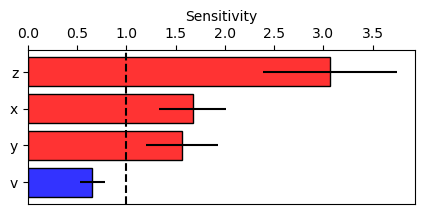

In [10]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

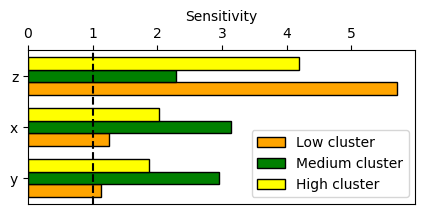

In [11]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'yellow']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=3, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

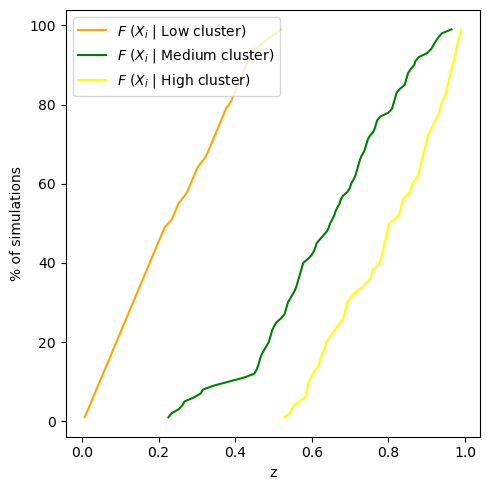

In [12]:
from pyDGSA.plot import plot_cdf

fig, ax = plot_cdf(parameters, labels, 'z', parameter_names=parameter_names, 
                   cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

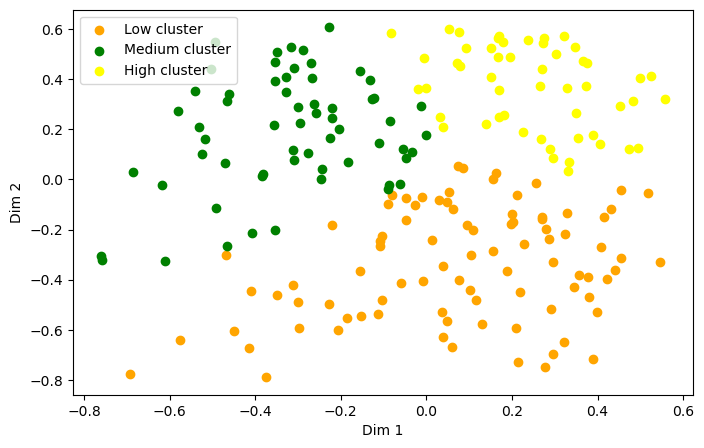

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

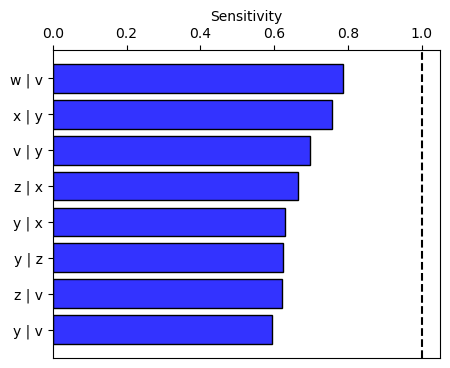

In [14]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

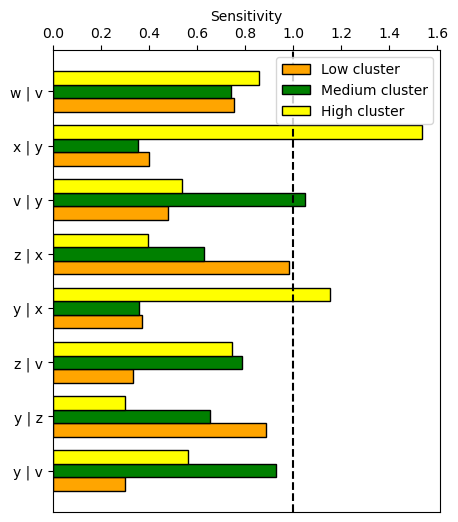

In [15]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

/mnt/data/Geology/Research/Modeling/custom_packages/pyDGSA/pyDGSA/plot.py:267: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = sens.append(nsens)


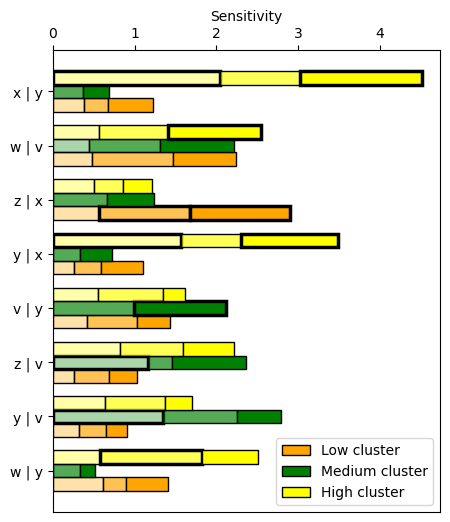

In [16]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)